# Looking at output from Tomtom algoritm for searching for motifs 

In [122]:
library(tidyverse)
library(GGally)
library(ggseqlogo)
library(reticulate)

In [70]:
# load the data (so far I've done 3 of the PWM types)
all_active = read.delim("../tomtom_scripts/results/PWMs_all_active_per_seq.tsv", sep = "\t")
max_active = read.delim("../tomtom_scripts/results/PWMs_max_active_per_seq.tsv", sep = "\t")
direct = read.delim("../tomtom_scripts/results/PWMs_direct.tsv", sep = "\t")

# save as list and remove the last 3 rows (incomplete cases)
tomtom = list(all = all_active, max = max_active, direct = direct)
tomtom = lapply(tomtom, function(df){
    df[complete.cases(df), ]
})

In [71]:
# dimensions of the output, finding a lot less matches in the all active set
sapply(tomtom, dim)

all,max,direct
238720,238720,238720
10,10,10


In [73]:
head(tomtom$max %>% arrange(E.value))

,Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
1,234,MA1137.1,2,2.47398e-08,1.84559e-05,3.54562e-05,8,ATGAGTCA,GTATGAGTCATCA,-
2,108,MA1138.1,0,3.47378e-08,2.59144e-05,4.51597e-05,8,GATGAGTC,GATGACTCAT,+
3,266,MA1137.1,3,4.35172e-08,3.24638e-05,6.24111e-05,8,TGACTCAT,TGATGACTCATAC,+
4,25,MA0098.3,2,4.61069e-08,3.43957e-05,6.75153e-05,8,AGGAAGTG,ACCGGAAGTG,+
5,108,MA1135.1,0,6.28007e-08,4.68493e-05,4.51597e-05,8,GATGAGTC,GATGACTCAT,+
6,70,MA0098.3,0,7.98396e-08,5.95603e-05,1.16750e-04,8,TACTTCCT,CACTTCCGGT,-


In [143]:
deepsea_dir = "../data/deepsea_train/"
predictor_names = read.delim(paste0(deepsea_dir, "predictor.names"), 
                             sep = "|", 
                             header = FALSE, 
                             col.names = c("cell_type", "data_type", "none")
                            )
jaspar_meta = read.delim("../data/jaspar_meta.txt", sep = " ")
predictor_names$cell_type %>% unique %>% length

[1] 148

In [153]:
tf_names <- (predictor_names %>% 
             mutate(tf_name_lower = tolower(str_remove(data_type, "-"))))$tf_name_lower %>%
    unique()
jaspar_meta = jaspar_meta %>% mutate(tf_name_lower = tolower(str_remove(tf_name, "-")))
in_jaspar = sapply(tf_names, function(x) sum(str_detect(jaspar_meta$tf_name_lower, x)))
in_jaspar = names(in_jaspar)[in_jaspar > 0]       
in_jaspar = in_jaspar[!is.na(in_jaspar)]
in_jaspar_col = sapply(1:nrow(jaspar_meta), function(i){
    ifelse(str_detect(jaspar_meta$tf_name_lower[i], 
                      str_c(in_jaspar, collapse="|")), "yes", "no")
})                   
jaspar_meta = jaspar_meta %>% 
    mutate(in_jaspar = in_jaspar_col)

In [65]:
sum(jaspar_meta$in_jaspar == "yes")

[1] 134

## Which TF are in JASPAR and DeepSEA


In [54]:
lapply(tomtom, function(df){
    (df %>% filter(E.value < 0.05))$Query_ID %>%
    unique() %>% length()
})

$all
[1] 28

$max
[1] 55

$direct
[1] 36

In [155]:
# total number of significant matches in max 
df <- tomtom$max %>% 
    mutate(in_deepsea = ifelse(
        Target_ID %in% jaspar_meta$matrix_id[jaspar_meta$in_jaspar == "yes"], 
        "yes", "no"))

# merge with TF name 
df <- df %>% merge(jaspar_meta, by.x = "Target_ID", by.y = "matrix_id")
(df %>% filter(E.value < 0.05 & in_deepsea == "no"))$tf_name %>% unique() %>% length()
(df %>% 
     filter(E.value < 0.05 & in_deepsea == "yes"))$tf_name %>% unique() %>% length()

[1] 69

[1] 34

In [157]:
(df %>% filter(E.value < 0.05 & in_deepsea == "no"))$tf_name %>% unique() %>% sort()

[1] BHLHA15(var.2) BHLHE22(var.2) CEBPA          CEBPE          CEBPG(var.2)  
 [6] EHF            ELF3           ELF5           ELK3           EN2           
[11] ERF            ERG            ESR2           ETV1           ETV2          
[16] ETV3           ETV5           ETV6           FEV            FIGLA         
[21] FLI1           FOS            FOS::JUN       FOS::JUNB      FOSB::JUNB    
[26] HIC2           INSM1          JDP2           JUN            JUN::JUNB     
[31] JUN(var.2)     JUNB           KLF14          KLF4           LHX1          
[36] Lhx8           MAF            MAFA           MNT            MYOG          
[41] NFIB           NFIX           NFIX(var.2)    NR2C1          NR2C2         
[46] NR2C2(var.2)   NR2F1          NR3C1          NR3C2          PLAGL2        
[51] POU4F1         POU4F3         PPARG          RARA::RXRG     RARA(var.2)   
[56] Rarg(var.2)    RELB           REST           Smad2::Smad3   Stat4         
[61] TCF4           TEAD1          TFAP4(var.2)   VEZF1          ZBTB7C        
[66] ZIC4           ZNF384         Znf423         ZNF740        
746 Levels: Ahr::Arnt Alx1 ALX3 Alx4 Ar ARGFX Arid3a Arid3b Arid5a ... ZSCAN4

In [159]:
(df %>% filter(in_deepsea == "yes"))$tf_name %>% unique() %>% sort()

[1] Arid3a             Atf1               ATF2              
  [4] ATF3               BACH1              Bach1::Mafk       
  [7] BATF               BATF::JUN          BATF3             
 [10] BHLHE40            CEBPB              CEBPD             
 [13] CREB1              CTCF               CTCFL             
 [16] E2F1               E2F4               E2F6              
 [19] EBF1               EGR1               EGR2              
 [22] EGR3               EGR4               ELF1              
 [25] ELK1               ELK4               ETS1              
 [28] FOS::JUND          FOSL1              FOSL1::JUN        
 [31] FOSL1::JUN(var.2)  FOSL1::JUNB        FOSL1::JUND       
 [34] FOSL1::JUND(var.2) FOSL2              FOSL2::JUN        
 [37] FOSL2::JUN(var.2)  FOSL2::JUNB        FOSL2::JUNB(var.2)
 [40] FOSL2::JUND        FOSL2::JUND(var.2) FOXA1             
 [43] FOXA2              FOXP2              GABPA             
 [46] GATA1              GATA1::TAL1        GATA2             
 [49] GATA3              GRHL1              GRHL2             
 [52] Hand1::Tcf3        HNF4A              HNF4A(var.2)      
 [55] HNF4G              HSF1               IKZF1             
 [58] IRF1               IRF3               IRF4              
 [61] JUND               JUND(var.2)        MAF::NFE2         
 [64] MAFF               MAFK               MAX               
 [67] MAX::MYC           MAZ                MEF2A             
 [70] MEF2C              MXI1               MYBL2             
 [73] NFATC1             NFE2               NFE2L1            
 [76] Nfe2l2             NFIC               NFIC::TLX1        
 [79] NFIC(var.2)        NFKB1              NFKB2             
 [82] NFYA               NFYB               NR1H2::RXRA       
 [85] Nr1h3::Rxra        NR1H4::RXRA        NR2F2             
 [88] NR4A2::RXRA        NRF1               PBX3              
 [91] POU2F2             POU5F1             Pou5f1::Sox2      
 [94] POU5F1B            PPARA::RXRA        Pparg::Rxra       
 [97] PRDM1              Prdm15             RARA::RXRA        
[100] RFX5               RUNX3              Rxra              
[103] RXRA::VDR          SP1                SP2               
[106] SP4                SREBF1             SREBF1(var.2)     
[109] SRF                STAT1              STAT1::STAT2      
[112] Stat2              STAT3              Stat5a            
[115] Stat5a::Stat5b     TAL1::TCF3         TBP               
[118] Tcf12              TCF12(var.2)       TCF3              
[121] TCF7L2             TEAD4              THAP1             
[124] THAP11             USF1               USF2              
[127] YY1                ZBTB33             ZBTB7A            
[130] ZEB1               ZKSCAN1            ZNF143            
[133] ZNF263             ZNF274            
746 Levels: Ahr::Arnt Alx1 ALX3 Alx4 Ar ARGFX Arid3a Arid3b Arid5a ... ZSCAN4

In [160]:
sig_tfs <- (df %>% 
     filter(E.value < 0.05 & in_deepsea == "yes"
           ))$tf_name %>% as.character
sig_querys <- (df %>% 
     filter(E.value < 0.05 & in_deepsea == "yes"
           ))$Query_ID %>% as.character
table(sig_tfs, sig_querys)
sig_tfs

                    sig_querys
sig_tfs              108 110 116 118 121 128 155 17 201 211 234 25 260 266 267
  BACH1                1   0   0   0   1   0   0  0   0   0   1  0   0   1   0
  Bach1::Mafk          1   0   0   0   0   0   0  0   0   0   1  0   0   1   0
  BATF                 1   0   0   0   1   0   0  0   0   0   1  0   0   1   1
  BATF::JUN            1   0   0   0   1   0   0  0   0   0   1  0   0   1   1
  BATF3                1   0   0   0   1   0   0  0   0   0   1  0   0   1   1
  CEBPB                0   0   1   0   0   0   0  0   0   1   0  0   0   0   0
  CTCF                 0   0   0   0   0   0   0  1   0   0   0  0   0   0   0
  CTCFL                0   0   0   0   0   0   0  0   0   0   0  0   0   0   0
  ELF1                 0   0   0   0   0   0   0  0   0   0   0  0   0   0   0
  ETS1                 0   0   0   0   0   0   0  0   0   0   0  1   0   0   0
  FOS::JUND            1   0   0   0   1   0   0  0   0   0   1  0   0   1   0
  FOSL1              

[1] "GABPA"              "GABPA"              "GABPA"             
  [4] "Pparg::Rxra"        "RXRA::VDR"          "ETS1"              
  [7] "ETS1"               "ZEB1"               "CTCF"              
 [10] "CTCF"               "CTCF"               "CTCF"              
 [13] "CTCF"               "Nfe2l2"             "Nfe2l2"            
 [16] "Nfe2l2"             "NFIC"               "BATF::JUN"         
 [19] "BATF::JUN"          "BATF::JUN"          "BATF::JUN"         
 [22] "BATF::JUN"          "BATF::JUN"          "CEBPB"             
 [25] "CEBPB"              "ELF1"               "FOSL1"             
 [28] "FOSL1"              "FOSL1"              "FOSL1"             
 [31] "FOSL1"              "FOSL2"              "FOSL2"             
 [34] "FOSL2"              "FOSL2"              "FOSL2"             
 [37] "JUND"               "JUND"               "JUND"              
 [40] "JUND"               "JUND"               "JUND(var.2)"       
 [43] "MAFK"               "MAFK"               "MAFK"              
 [46] "MAFK"               "Bach1::Mafk"        "Bach1::Mafk"       
 [49] "Bach1::Mafk"        "Bach1::Mafk"        "NFATC1"            
 [52] "BATF3"              "BATF3"              "BATF3"             
 [55] "BATF3"              "BATF3"              "BATF3"             
 [58] "CTCFL"              "CTCFL"              "FOSL1::JUN"        
 [61] "FOSL1::JUN"         "FOSL1::JUN"         "FOSL1::JUN"        
 [64] "FOSL1::JUN"         "FOSL2::JUN"         "FOSL2::JUN"        
 [67] "FOSL2::JUN"         "FOSL2::JUN"         "FOSL2::JUN"        
 [70] "FOSL1::JUNB"        "FOSL1::JUNB"        "FOSL1::JUNB"       
 [73] "FOSL1::JUNB"        "FOSL1::JUNB"        "FOSL2::JUNB"       
 [76] "FOSL2::JUNB"        "FOSL2::JUNB"        "FOSL2::JUNB"       
 [79] "FOSL2::JUNB"        "FOS::JUND"          "FOS::JUND"         
 [82] "FOS::JUND"          "FOS::JUND"          "FOS::JUND"         
 [85] "FOSL1::JUND"        "FOSL1::JUND"        "FOSL1::JUND"       
 [88] "FOSL1::JUND"        "FOSL1::JUND"        "FOSL1::JUND(var.2)"
 [91] "FOSL2::JUND"        "FOSL2::JUND"        "FOSL2::JUND"       
 [94] "FOSL2::JUND"        "FOSL2::JUND"        "IKZF1"             
 [97] "NFIC(var.2)"        "Prdm15"             "Stat5a"            
[100] "BACH1"              "BACH1"              "BACH1"             
[103] "BACH1"              "BACH1"              "BATF"              
[106] "BATF"               "BATF"               "BATF"              
[109] "BATF"               "BATF"

In [117]:
# make a plot that shows the density of genes that 
png("../out/figures/p_val_hist.png", width = 600)
ggplot(df) + 
    geom_density(aes(E.value, fill = in_jaspar), alpha = 0.5) + 
    scale_fill_discrete("DeepSEA feature") + 
    labs(x = "P value") + 
    theme_classic()
dev.off()

png 
  2

In [ ]:
ggplot(df) + 
    geom_density(aes(E.value, fill = in_jaspar), alpha = 0.5) + 
    scale_fill_discrete("DeepSEA feature") + 
    labs(x = "P value") + 
    theme_classic()

In [138]:
# looking at the 4 TFs from TF Modisco
df %>% filter(tf_name %in% c("EGR1")) %>% arrange(E.value) %>% head(2)

,Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
1,MA0162.4,15,6,0.000678097,0.505860,0.275011,8,CCACAGCC,CCACGCCCACGCCC,+,yes,EGR1,egr1,yes
2,MA0162.4,249,0,0.000993798,0.741373,0.362540,8,ATACACCC,CCACGCCCACGCCC,+,yes,EGR1,egr1,yes


In [139]:
df %>% filter(tf_name %in% c("ELF1")) %>% arrange(E.value) %>% head(2)

,Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
1,MA0473.3,53,1,1.00839e-05,0.00752258,0.00499296,8,AACAGGAA,AAACAGGAAGTGGG,+,yes,ELF1,elf1,yes
2,MA0473.3,25,4,1.09000e-04,0.08131430,0.00938892,8,AGGAAGTG,AAACAGGAAGTGGG,+,yes,ELF1,elf1,yes


In [140]:
df %>% filter(tf_name %in% c("CEBPB")) %>% arrange(E.value) %>% head(2)

,Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
1,MA0466.2,211,2,1.00012e-05,0.00746091,0.00739484,8,TGCCTAAT,ATTGCGCAAT,-,yes,CEBPB,cebpb,yes
2,MA0466.2,116,0,3.86260e-05,0.02881500,0.02826540,8,ATTACGCA,ATTGCGCAAT,+,yes,CEBPB,cebpb,yes


In [141]:
df %>% filter(tf_name %in% c("E2F6")) %>% arrange(E.value) %>% head(2)

,Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
1,MA0471.2,194,5,0.00198751,1.48268,0.113990,8,CCCCCCAC,CCTTCCCGCCCCC,-,yes,E2F6,e2f6,yes
2,MA0471.2,260,5,0.00200054,1.49240,0.173029,8,CAGGAAAT,GGGGGCGGGAAGG,+,yes,E2F6,e2f6,yes


## CTCF and JUNB
No matches for CTCF

In [125]:
# CTCF filter 
df %>% filter(tf_name == "CTCF" & E.value < 0.05) %>% arrange(E.value) 

Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
MA0139.1,276,2,1.15912e-07,8.64704e-05,0.000172062,8,GCGCCACC,TAGCGCCCCCTGGTGGCCA,-,yes,CTCF,ctcf,yes
MA0139.1,79,9,4.82038e-07,3.59600e-04,0.000703873,8,GGGGGCAG,TGGCCACCAGGGGGCGCTA,+,yes,CTCF,ctcf,yes
MA0139.1,279,3,7.89902e-07,5.89267e-04,0.001178530,8,CGCCCTCT,TAGCGCCCCCTGGTGGCCA,-,yes,CTCF,ctcf,yes
MA0139.1,17,4,2.18722e-05,1.63167e-02,0.032633400,8,CTCCAGGT,TGGCCACCAGGGGGCGCTA,+,yes,CTCF,ctcf,yes
MA0139.1,292,8,4.14466e-05,3.09191e-02,0.045619700,8,AGGGGGCG,TGGCCACCAGGGGGCGCTA,+,yes,CTCF,ctcf,yes


In [133]:
# JUNB filter 
df %>% filter(tf_name == "JUNB" & E.value < 0.05) %>% arrange(E.value) 

Target_ID,Query_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation,in_deepsea,tf_name,tf_name_lower,in_jaspar
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<fct>,<chr>,<chr>
MA0490.2,121,4,5.34716e-06,0.00398898,0.000265181,8,GACTCATA,AAATGACTCATTT,+,no,JUNB,junb,no
MA0490.2,108,1,5.46638e-06,0.00407792,0.000291174,8,GATGAGTC,AAATGAGTCATTT,-,no,JUNB,junb,no
MA0490.2,304,3,1.19925e-05,0.00894639,0.000477423,8,TGACTCAT,AAATGAGTCATTT,-,no,JUNB,junb,no
MA0490.2,266,3,1.38643e-05,0.01034280,0.000568107,8,TGACTCAT,AAATGAGTCATTT,-,no,JUNB,junb,no
MA0490.2,234,2,1.89139e-05,0.01410980,0.000718020,8,ATGAGTCA,AAATGACTCATTT,+,no,JUNB,junb,no


## CTCFL (not in by feature results) - for presentation

In [26]:
jaspar_ids = (pred_names_with_jaspar)$matrix_id %>% 
    as.character() %>% unique
jaspar_ids

[1] "MA1632.1" "MA0605.2" "MA1634.1" "MA0464.2" "MA0466.2" "MA0836.2"
 [7] "MA0018.4" "MA0139.1" "MA1102.2" "MA0024.3" "MA0470.2" "MA0471.2"
[13] "MA0154.4" "MA0473.3" "MA0028.2" "MA0076.2" "MA0098.3" "MA0477.2"
[19] "MA0478.1" "MA0148.4" "MA0047.3" "MA0593.1" "MA0036.3" "MA0037.3"
[25] "MA0114.4" "MA0484.2" "MA0486.2" "MA1508.1" "MA0050.2" "MA1418.1"
[31] "MA1419.1" "MA1522.1" "MA0052.4" "MA0497.1" "MA0777.1" "MA0624.1"
[37] "MA0161.2" "MA1111.1" "MA0507.1" "MA1115.1" "MA0508.3" "MA0510.2"
[43] "MA0684.2" "MA0079.4" "MA0516.2" "MA0685.1" "MA0083.3" "MA0137.3"
[49] "MA0144.2" "MA0108.2" "MA0522.3" "MA0523.1" "MA0809.2" "MA0597.1"
[55] "MA0093.3" "MA0526.3" "MA0095.2" "MA0527.1" "MA0750.2" "MA0103.3"
[61] "MA1585.1" "MA0528.2" "MA1592.1"

In [25]:
head(pred_names_with_jaspar)

,tf_name,matrix_id,index,cell_type
,<fct>,<fct>,<int>,<fct>
1,ATF2,MA1632.1,205,GM12878
2,ATF2,MA1632.1,260,H1-hESC
3,ATF3,MA0605.2,595,K562
4,ATF3,MA0605.2,261,H1-hESC
5,ATF3,MA0605.2,296,HepG2
6,ATF3,MA0605.2,171,A549


In [31]:
lapply(tomtom, function(df){
    table((df %>% filter(Target_ID %in% jaspar_ids))$Query_ID, 
          (df %>% filter(Target_ID %in% jaspar_ids))$Target_ID
         )
})

$all
    
     MA0018.4 MA0036.3 MA0037.3 MA0050.2 MA0052.4 MA0108.2 MA0497.1 MA0507.1
  5         0        0        0        0        0        1        0        0
  8         0        1        0        0        0        0        0        0
  10        0        0        0        0        0        1        0        0
  47        0        0        0        0        0        1        0        0
  53        0        0        0        1        1        0        1        0
  60        0        0        0        0        0        1        0        0
  61        1        1        1        0        1        1        0        1
  68        0        0        0        0        0        1        0        0
  74        0        0        0        0        0        1        0        0
    
     MA0809.2 MA1115.1
  5         0        0
  8         0        0
  10        0        0
  47        0        0
  53        0        0
  60        0        0
  61        1        1
  68        0        0
  74    

## Looking at by TF results

In [27]:
# load the metadata files 
deepsea_dir = "../data/deepsea_train/"
predictor_names = read.delim(paste0(deepsea_dir, "predictor.names"), 
                             sep = "|", 
                             header = FALSE, 
                             col.names = c("cell_type", "data_type", "none")
                            )
jaspar_meta = read.delim("../data/jaspar_meta.txt", sep = " ")
pred_names_with_jaspar = read.delim(paste0(deepsea_dir, 
                                           "predictor_names_in_jaspar.txt"), 
                                    sep = " "
                                   )

In [14]:
tomtom_dir = "../tomtom_scripts/results/PWMs_max_active_per_seq_yobserved_1"
files = list.files(tomtom_dir)

In [15]:
tomtom = lapply(files, function(file){
    read.delim(paste0(tomtom_dir, "/", file), sep = "\t") %>%
        arrange(p.value)
})
indices = sapply(files, function(file){
    index = str_extract_all(file, "[0-9]") %>% unlist()
    paste(index, collapse = '') %>% as.numeric
})
names(indices) = NULL

In [16]:
head(tomtom[[1]])

,Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
1,233,MA1549.1,0,4.73765e-07,0.000353428,0.000643267,8,ATCTCATT,ACCTCATTAT,-
2,205,MA1637.1,5,9.65633e-07,0.000720362,0.001440720,8,AAGGGAGG,TTCCCAAGGGAAT,+
3,205,MA1604.1,5,2.83919e-06,0.002118030,0.002118030,8,AAGGGAGG,TTCCCAAGGGACT,+
4,51,MA1652.1,6,4.07906e-06,0.003042980,0.006085950,8,AGTGAGGG,GGAGGAGGTGAGAA,+
5,278,MA1649.1,2,5.95685e-06,0.004443810,0.008887620,8,GTTCCAGA,GGGTTCCAGAT,-
6,143,MA0790.1,2,6.79414e-06,0.005068430,0.009347540,8,ATAATTAT,CATTAATTATTCAT,-


In [17]:
# look through all CTCF data and see if the CTCF motif is every matched 
ctcf_indices = which(str_detect(predictor_names$data_type, "CTCF")) %>%
    intersect(indices)
ctcf_matrix_id = "MA0139.1"
ctcf_match = lapply(ctcf_indices, function(i){
    tomtom[[which(indices == i)]] %>%
        filter(Target_ID == ctcf_matrix_id)
})
names(ctcf_match) = paste0("X", ctcf_indices)

In [18]:
ctcf_match[[1]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.00184747,1.37821,0.219906,8,GTTCCCCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.01087050,8.10936,0.426144,8,CCCCCTTT,TAGCGCCCCCTGGTGGCCA,-


In [19]:
ctcf_match[[2]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.000789211,0.588751,0.103701,8,GGTCCCCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.009568070,7.137780,0.360975,8,CCCCCTCT,TAGCGCCCCCTGGTGGCCA,-


In [20]:
ctcf_match[[3]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.00170681,1.27328,0.202614,8,GGTCCCCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.01229860,9.17473,0.477175,8,CCCCCTCT,TAGCGCCCCCTGGTGGCCA,-


In [21]:
# looking at overlap in filter indices across all the different CTCF features 
filter_overlap = lapply(1:length(ctcf_indices), function(i){
    ctcf_match[[i]]$Query_ID
}) %>% unlist
table(filter_overlap)

filter_overlap
 47  79 124 194 
 63  28  61   1 

In [22]:
# check for the rank of the matching filter
i = ctcf_indices[1]
ctcf_match_rank = tomtom[[which(indices == i)]] %>%
                    mutate(match_rank = order(p.value), 
                           feature_index = i
                          ) %>%
                    filter(Target_ID == ctcf_matrix_id) %>%
                    select(match_rank, Query_ID, feature_index)
for(i in ctcf_indices[-1]) {
    ctcf_match_rank = rbind(ctcf_match_rank, 
    tomtom[[which(indices == i)]] %>%
        mutate(match_rank = order(p.value), 
               feature_index = i
              ) %>%
        filter(Target_ID == ctcf_matrix_id) %>%
        select(match_rank, Query_ID, feature_index))
}

In [23]:
head(ctcf_match_rank)

,match_rank,Query_ID,feature_index
,<int>,<int>,<dbl>
1,447,47,174
2,1238,124,174
3,259,47,339
4,1214,124,339
5,424,47,723
6,1293,124,723


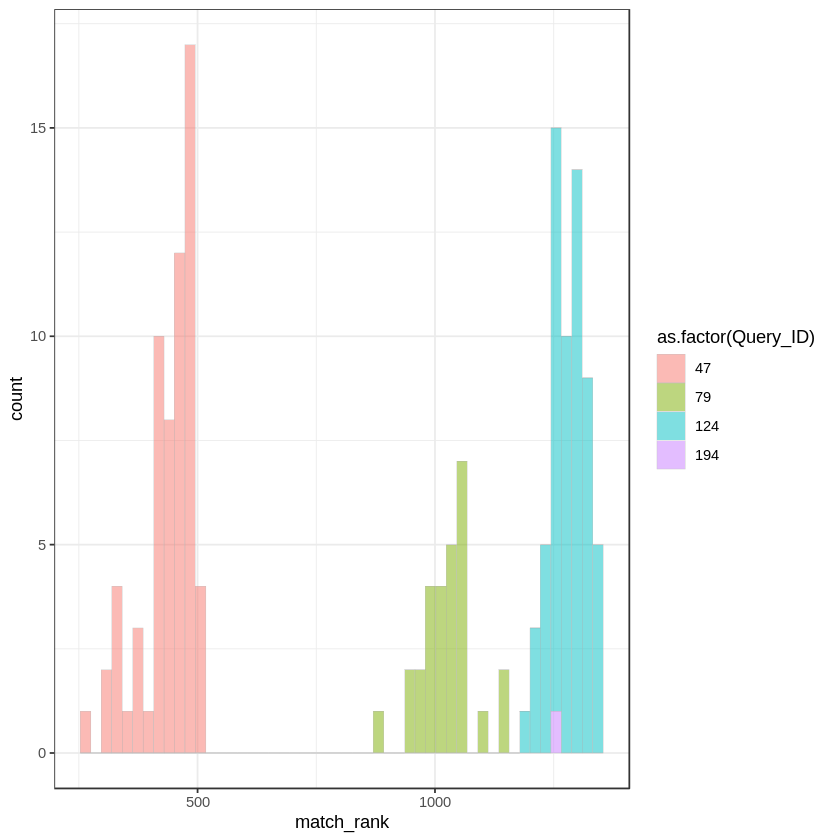

In [24]:
ggplot(ctcf_match_rank) + 
    geom_histogram(aes(match_rank, 
                       fill = as.factor(Query_ID)), 
                   color = "grey", size = 0.1,
                   bins = 50, alpha = 0.5
                  ) + 
    theme_bw() 

In [25]:
# checking which CTCF features had highest rank for each filter
filters = ctcf_match_rank$Query_ID %>% unique
sapply(filters, function(i){
    df = ctcf_match_rank %>% filter(Query_ID == i)
    df$feature_index[which.min(df$match_rank)]
})
filters

[1] 339 792 805 814

[1]  47 124  79 194

In [26]:
ctcf_match[[paste0("X", 339)]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.000789211,0.588751,0.103701,8,GGTCCCCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.009568070,7.137780,0.360975,8,CCCCCTCT,TAGCGCCCCCTGGTGGCCA,-


In [83]:
ctcf_match[[paste0("X", 792)]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.00172290,1.28528,0.204288,8,GGTCCCCC,TAGCGCCCCCTGGTGGCCA,-
79,MA0139.1,6,0.00871178,6.49899,0.492105,8,CCCCTGCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.00993257,7.40970,0.388480,8,CCCCCTCT,TAGCGCCCCCTGGTGGCCA,-


In [84]:
ctcf_match[[paste0("X", 805)]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.00204219,1.52347,0.201125,8,GTTCCCCC,TAGCGCCCCCTGGTGGCCA,-
79,MA0139.1,6,0.00552355,4.12057,0.389385,8,CCCCTGCC,TAGCGCCCCCTGGTGGCCA,-
124,MA0139.1,5,0.01244660,9.28513,0.484052,8,CCCCCTTT,TAGCGCCCCCTGGTGGCCA,-


In [85]:
ctcf_match[[paste0("X", 814)]]

Query_ID,Target_ID,Optimal_offset,p.value,E.value,q.value,Overlap,Query_consensus,Target_consensus,Orientation
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>
47,MA0139.1,2,0.00137748,1.02760,0.164871,8,GGTCCCCC,TAGCGCCCCCTGGTGGCCA,-
194,MA0139.1,9,0.01248980,9.31738,0.498370,8,GGGGGGAG,TGGCCACCAGGGGGCGCTA,+


## Looking at the single filter

### Filter 3

In [7]:
# load the data (so far I've done 3 of the PWM types)
tomtom = read.delim("../tomtom_scripts/results/PWMs_filter3.tsv", sep = "\t")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



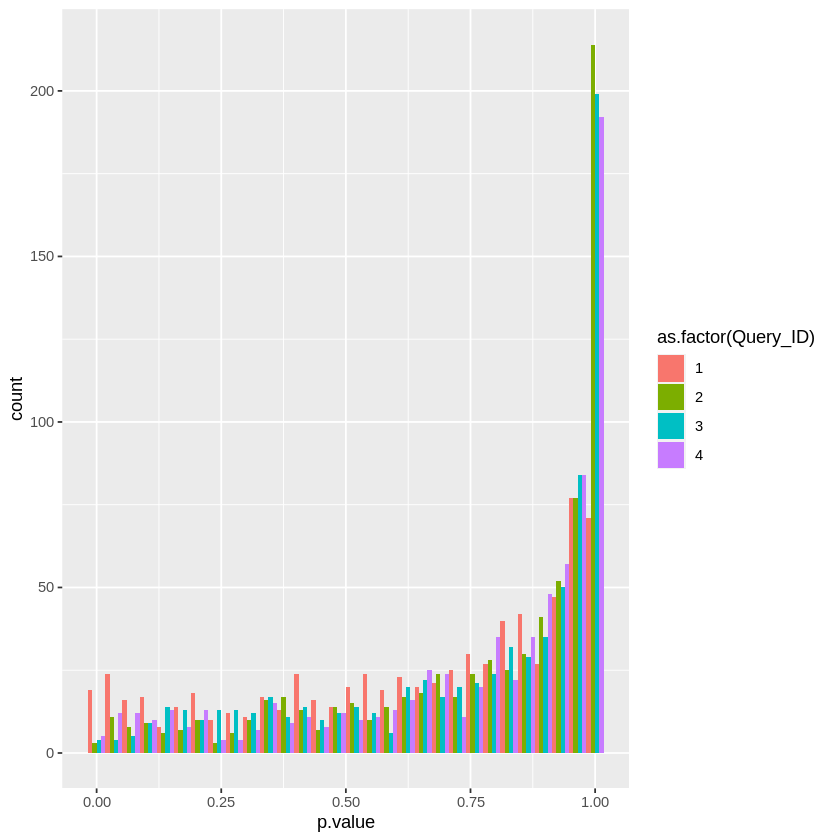

In [14]:
ggplot(tomtom) + 
    geom_histogram(aes(p.value, 
                       fill = as.factor(Query_ID), 
                       group = as.factor(Query_ID)), 
                   position = 'dodge')

In [9]:
tomtom$Query_ID %>% unique()

[1] 1 2 3 4

In [24]:
q1 <- tomtom %>% filter(Query_ID == 1) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query1)
q2 <- tomtom %>% filter(Query_ID == 2) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query2)
q3 <- tomtom %>% filter(Query_ID == 3) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query3)
q4 <- tomtom %>% filter(Query_ID == 4) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query4)
together <- merge(q1, q2) %>% merge(q3) %>% merge(q4)

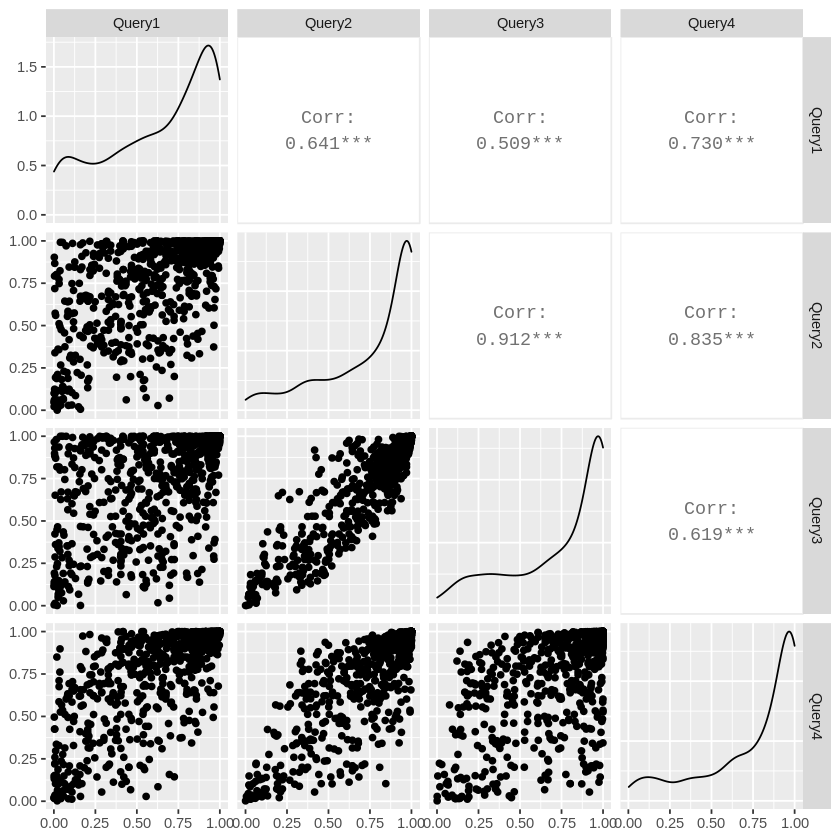

In [38]:
ggpairs(together, columns = 2:5)

### Filter 233

In [3]:
# load the data (so far I've done 3 of the PWM types)
tomtom = read.delim("../tomtom_scripts/results/PWMs_filter233.tsv", sep = "\t")

q1 <- tomtom %>% filter(Query_ID == 1) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query1)
q2 <- tomtom %>% filter(Query_ID == 2) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query2)
q3 <- tomtom %>% filter(Query_ID == 3) %>% 
    pivot_wider(names_from = Query_ID,
                values_from = p.value,
                names_prefix = "Query"
               ) %>%
    select(Target_ID, Query3)
together <- merge(q1, q2) %>% merge(q3)

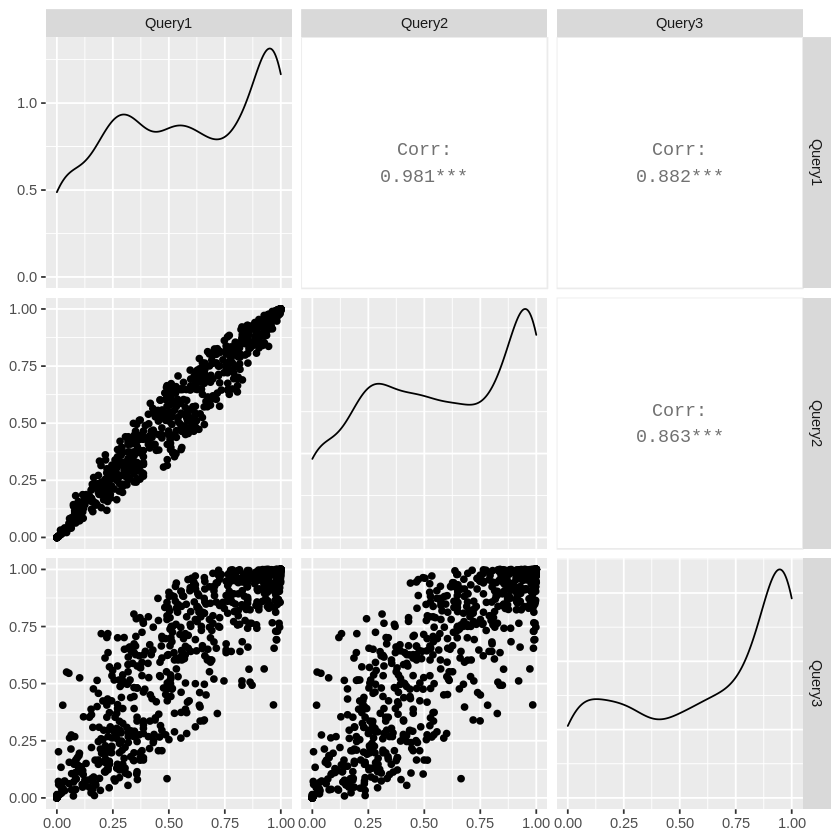

In [5]:
ggpairs(together, columns = 2:4)

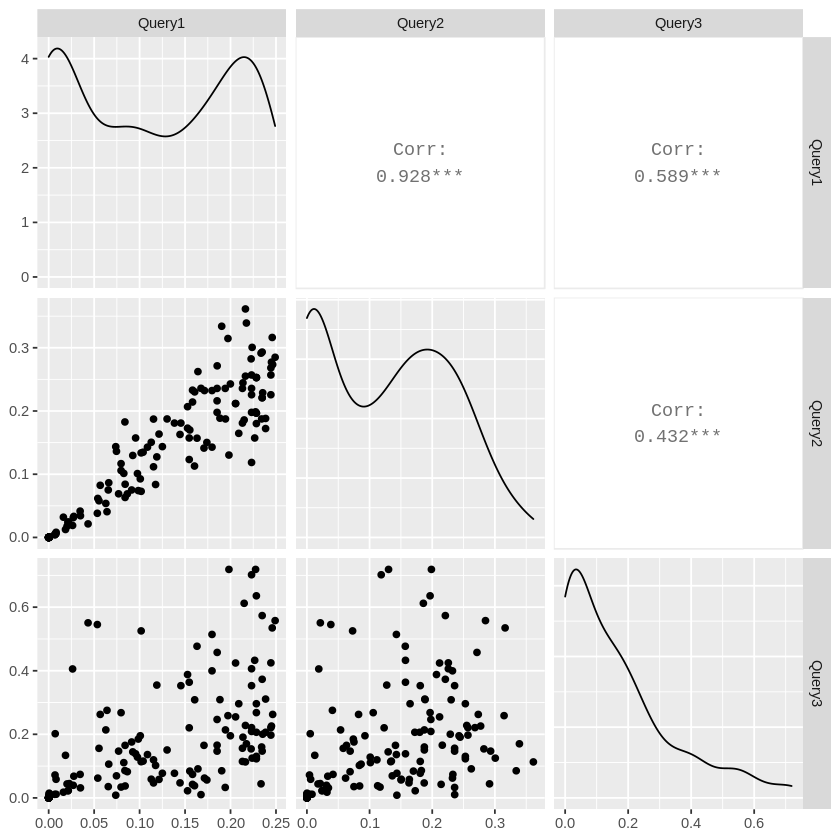

In [7]:
ggpairs(together %>% filter(Query1 < 0.25), columns = 2:4)